<a href="https://colab.research.google.com/github/CHUNGSEYEON991108/Credit12/blob/main/20240915_3-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#module

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.layers import Dense, Dropout

# Data Load

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Detect credit card anomalies/creditcard.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [4]:
# data.info() #결측치 없음
data['Class'].value_counts()

,count
Class,
0,284315
1,492


# Train, Test 분리

## Oversampling

In [5]:
# 1. X, y 분리
X= data.iloc[:, :-1] # Time~Amount
Y= data.iloc[:, -1] # Class

# 2. Oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# 2. 데이터 정규화 (각 특징에 대해 0~1 사이 값으로 변환)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled) # X데이터를 scaling
X = pd.DataFrame(X_scaled, index=X_resampled.index, columns=X_resampled.columns) # X_scaled는 numpy이므로 DataFrame으로 변경

# 3. train, test 분리
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, test_index in kfold.split(X, Y_resampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y_resampled.iloc[train_index], Y_resampled.iloc[test_index]

print(X_train.shape, y_train.shape) #(227846, 30) (227846,) 80%
print(X_test.shape, y_test.shape) #(56961, 30) (56961,) 20%

(454904, 30) (454904,)
(113726, 30) (113726,)


In [7]:
Y_resampled.value_counts()

,count
Class,
0,284315
1,284315


# Train, Test 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


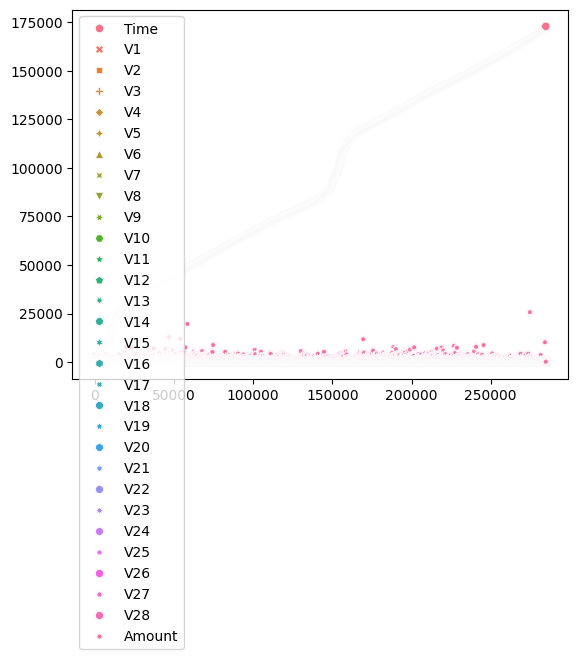

In [ ]:
import seaborn as sns
sns.scatterplot(X_train)
plt.show()

# Hyperparameter

## learning_rate_decay 변경
    exponential -> cosine -> inverse


In [8]:
# 1. 학습률
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 5
decay_rate = 0.95
epochs = np.arange(1, 101)

# Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

## Learning Rate Decay Visualization

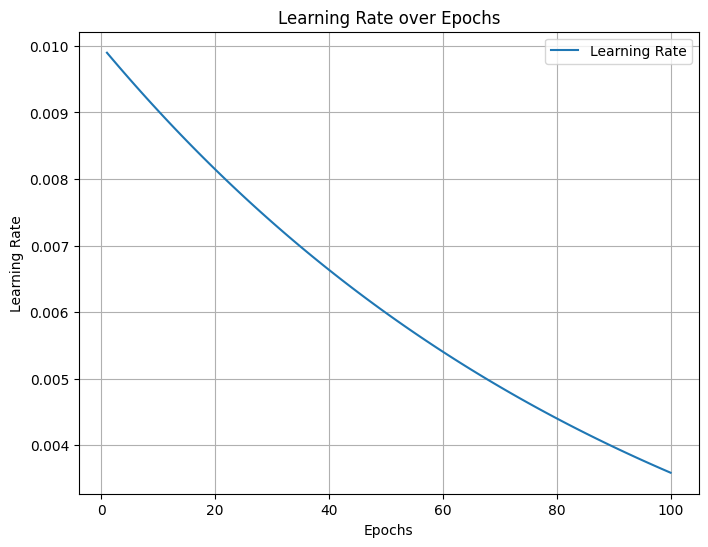

In [9]:
# Exponential Decay 체크
learning_rate_check = []
for epoch in epochs:
    learning_rate = exponential_decay(epoch)
    learning_rate_check.append(learning_rate.numpy())

# 학습율 시각화
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rate_check, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# model 구축

## 가중치 초기화

In [10]:
print(X_train.shape[1])

30


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential()

#가중치 초기화
weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializaers.RandomNormal()
# weight_init = tf.keras.initializaers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # 두 번째 은닉층
model.add(Dropout(0.5))  # 50% 드롭아웃 적용
model.add(Dense(32, activation='relu')) # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# Optimizer

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exponential_decay),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training

In [13]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=len(epochs), validation_data=(X_train, y_train), batch_size = batch_size)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8538 - loss: 0.3057 - val_accuracy: 0.9724 - val_loss: 0.0803
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9667 - loss: 0.0998 - val_accuracy: 0.9735 - val_loss: 0.0751
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9697 - loss: 0.0913 - val_accuracy: 0.9745 - val_loss: 0.0721
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9702 - loss: 0.0882 - val_accuracy: 0.9752 - val_loss: 0.0704
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9709 - loss: 0.0868 - val_accuracy: 0.9751 - val_loss: 0.0704
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9705 - loss: 0.0868 - val_accuracy: 0.9753 - val_loss: 0.0699
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9707 - loss: 0.0863 - val_accuracy: 0.9752 - val_loss: 0.0700
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9710 - loss: 0.0862 - 

## Training Loss and Val_Loss Visualization

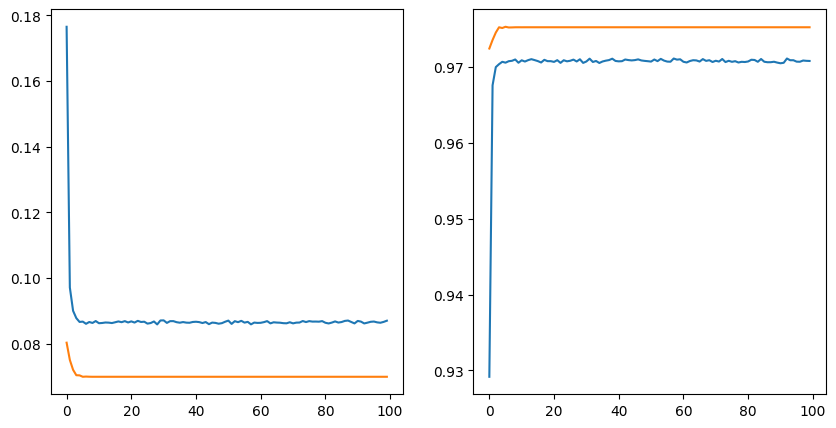

In [14]:
history_df = pd.DataFrame(history.history)
# print(history_df)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history_df.loc[:, ['loss', 'val_loss']])
plt.subplot(122)
plt.plot(history_df.loc[:, ['accuracy', 'val_accuracy']])

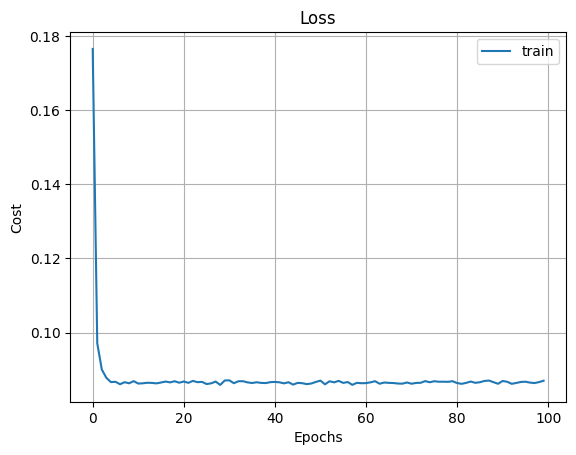

In [15]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Model Evaluation

In [16]:
eval_loss, eval_acc = model.evaluate(X_test, y_test)
print(f"evaluation_acc = {eval_acc}")
print(f"evaluation_loss = {eval_loss}")

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9809 - loss: 0.0655
evaluation_acc = 0.973963737487793
evaluation_loss = 0.07349471002817154


# Test

In [17]:
y_pred = model.predict(X_test)

print(y_pred[0])
print(y_test[0])

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
[0.07562283]
0


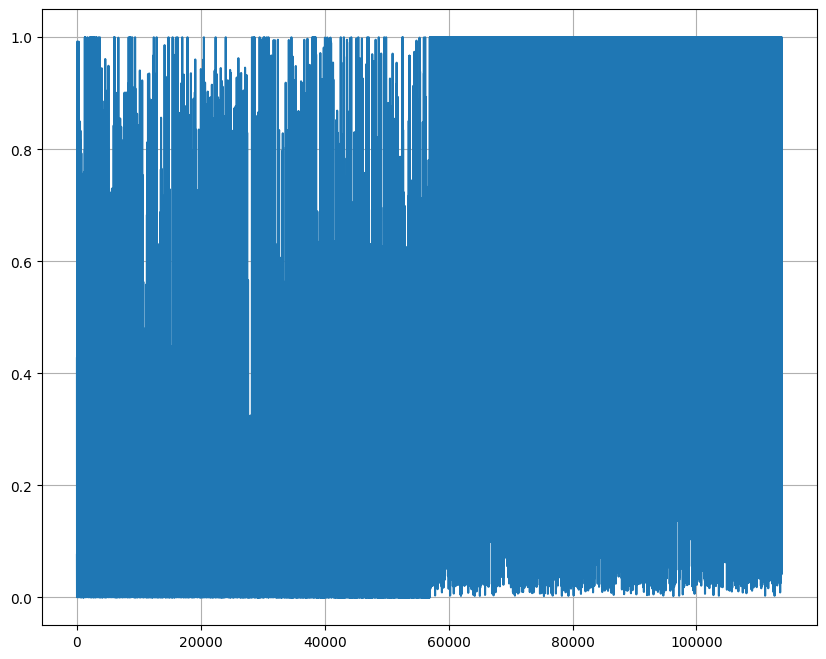

In [18]:
plt.figure(figsize=(10,8))
plt.plot(y_pred) #그래프모양 변경가능
plt.grid()
plt.show()

In [35]:
# preds_1d = y_pred.flatten() # 차원 펴주기
# pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 1, 작으면 0
# pred_class=pd.DataFrame(pred_class)
# pred_class.value_counts()

# y_test.value_counts()
pred_class = np.where(y_pred > 0.5, 1 , 0)
pred_class=pd.DataFrame(pred_class)
pred_class.value_counts()
# from sklearn.metrics import recall_score
# print(recall_score(y_test, pred_class))
#pd.DataFrame(X_scaled, index=X_resampled.index, columns=X_resampled.columns)

,count
0,
0,58122
1,55604


#Revised Recall

In [28]:
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 1, 작으면 0

from sklearn.metrics import recall_score
print(recall_score(y_test, pred_class))

0.9628932697887906
